In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats
from scipy import interpolate
from glob import glob

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *

from scipy.stats import skew, kurtosis

In [3]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [4]:
exp_meta_data_dir = '../meta_data/exp'
exp_data_dir = '../processed_data/exp'
sim_data_dir = '../processed_data/sim'

fig_dir = 'Figures/Supplementary_figures/quant_ver_fig5'

# Load data from experiments

In [5]:
# Load meta data
manifest_path = os.path.join(exp_meta_data_dir, 'ecephys_cache_dir_10_31', "manifest.json")
#manifest_path = os.path.join(exp_meta_data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## CSD

In [6]:
channels = cache.get_channels()
probes = cache.get_probes()

In [7]:
trial_window_start = -1.0
trial_window_end = 0.5


loadpaths_csd = sorted(glob(os.path.join(exp_data_dir, 'csd', 
            'trial_window_'+str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*.npy')))
loadpaths_lfp = sorted(glob(os.path.join(exp_data_dir, 'lfp', 'trial_window_'\
             +str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*.npy')))
    
len(loadpaths_csd)

53

In [8]:
twoi_start = -0.0
twoi_end = 0.1

Fs = 1250 # Hz

In [9]:
twoi_start = -0.0
twoi_end = 0.1

Fs = 1250 # Hz

session_ids = list() # all session ids
sessions_channels_vert_pos = dict()
sessions_csd_trial_avg = dict()
sessions_csd_all_trials = dict()
sessions_channel_ids_csd = dict()

for i, file_path in enumerate(loadpaths_csd):
    session_id = os.path.basename(file_path).split('_')[0]
    print('Session id: ', session_id)
    data = np.load(file_path, allow_pickle = True)
        
    session_ids.append(session_id)
        
    t = np.array(data[()]['csd_mean']['time_from_presentation_onset'])
    t_min = twoi_start; t_max = twoi_end
    mask = np.logical_and(t>=t_min, t<=t_max)
    t = t[mask]
    
    channels_vert_pos = data[()]['channel_vertical_pos']
    channels_vert_pos = channels_vert_pos[::-1]
    channels_vert_pos -= channels_vert_pos.max()
    sessions_channels_vert_pos[session_id] = channels_vert_pos
    
    mask_session = channels['ecephys_session_id'] == int(session_id)
    mask_structure = channels[mask_session]['ecephys_structure_acronym'] == 'VISp'
    dorsal_ventral_ccf_coordinate = channels[mask_session][mask_structure]['dorsal_ventral_ccf_coordinate']
    channel_ids_csd = data[()]['csd_mean'].channel.values
    dorsal_ventral_ccf_coordinate = -(dorsal_ventral_ccf_coordinate[channel_ids_csd]-dorsal_ventral_ccf_coordinate[channel_ids_csd].min())# higher dorsal-ventral value means more ventral
    
    if ~np.all(np.isnan(dorsal_ventral_ccf_coordinate)): # if all NaNs it means exact probe location not recovered
        csd_trial_avg = data[()]['csd_mean']
        csd_trial_avg = csd_trial_avg[:,mask]
        sessions_csd_trial_avg[session_id] = csd_trial_avg.values

        csd_all_trials = data[()]['csd']
        csd_all_trials = csd_all_trials[:,:,mask]
        sessions_csd_all_trials[session_id] = csd_all_trials.values
        
        sessions_channel_ids_csd[session_id] = channel_ids_csd

Session id:  715093703
Session id:  719161530
Session id:  721123822
Session id:  732592105
Session id:  737581020
Session id:  739448407
Session id:  742951821
Session id:  744228101
Session id:  746083955
Session id:  750332458
Session id:  750749662
Session id:  751348571
Session id:  754312389
Session id:  754829445
Session id:  755434585
Session id:  756029989
Session id:  757216464
Session id:  757970808
Session id:  758798717
Session id:  759883607
Session id:  760345702
Session id:  760693773
Session id:  761418226
Session id:  762120172
Session id:  762602078
Session id:  763673393
Session id:  766640955
Session id:  767871931
Session id:  768515987
Session id:  771160300
Session id:  771990200
Session id:  773418906
Session id:  774875821
Session id:  778240327
Session id:  778998620
Session id:  779839471
Session id:  781842082
Session id:  786091066
Session id:  787025148
Session id:  789848216
Session id:  791319847
Session id:  793224716
Session id:  794812542
Session id:

### Load channel depth data

In [10]:
#filename = 'cortical_depth_'+str(session_id)+'.csv'
#loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth


#### Remove faulty channels

In [11]:
structure = 'VISp'
sessions_channels_cort_depth = dict()

for session_id in sessions_df_depth.keys():
    df_depth = sessions_df_depth[session_id]
    mask_structure = df_depth.ecephys_structure_acronym == structure
    df_depth = df_depth[mask_structure]
    channels_cort_depth = df_depth.cortical_depth
        
    if session_id in sessions_channel_ids_csd.keys():
        print('Session ID: ', session_id)
        
        channel_ids_csd = sessions_channel_ids_csd[session_id]
    
        channels_cort_depth = channels_cort_depth[channel_ids_csd]      
        sessions_channels_cort_depth[session_id] = channels_cort_depth.values
        
print('\n ---------------------------------------------- \n')
sessions_channels_cort_depth_cleaned = dict()
for session_id, channels_cort_depth in sessions_channels_cort_depth.items():
    channels_cort_depth = channels_cort_depth[::-1]
    
    mask_nan = np.isnan(channels_cort_depth)
    
    channels_cort_depth_no_nan = channels_cort_depth[~mask_nan][::-1]
    
    if mask_nan.sum() > 0:
        print('Session ID: ', session_id, 'has NaN channels', channels_cort_depth, '\n', channels_cort_depth_no_nan, '\n', len(channels_cort_depth_no_nan))
        
    mask_zeros_after_1st_chan = channels_cort_depth_no_nan == 0
    
    if mask_zeros_after_1st_chan[1:].sum() > 0:
        end_chan = np.where(mask_zeros_after_1st_chan[1:])[0][0]+1

        channels_cort_depth_cleaned = channels_cort_depth_no_nan[:end_chan]

        print('Session ID: ', session_id, 'has channels outside cortex. Removed.', \
              channels_cort_depth_no_nan, '\n', channels_cort_depth_cleaned, len(channels_cort_depth_cleaned))
    
        sessions_channels_cort_depth_cleaned[session_id] = channels_cort_depth_cleaned
    else:
        sessions_channels_cort_depth_cleaned[session_id] = channels_cort_depth_no_nan
        
sessions_csd_trial_avg_short = dict()
sessions_csd_all_trials_short = dict()
for isess, session_id in enumerate(sessions_csd_trial_avg.keys()):
    csd_trial_avg = sessions_csd_trial_avg[session_id]
    csd_all_trials = sessions_csd_all_trials[session_id]
    
    channels_vert_pos = sessions_channels_vert_pos[session_id]
    
    cut_off_chan = len(sessions_channels_cort_depth_cleaned[session_id])
    
    #print(isess, session_id, csd_trial_avg.shape[0], channels_vert_pos[-1], \
    #      channels_vert_pos[:cut_off_chan].shape, channels_vert_pos[:cut_off_chan][-1])#,\

    sessions_csd_trial_avg_short[session_id] = csd_trial_avg[:cut_off_chan]
    sessions_csd_all_trials_short[session_id] = csd_all_trials[:cut_off_chan]

Session ID:  715093703
Session ID:  719161530
Session ID:  721123822
Session ID:  744228101
Session ID:  750749662
Session ID:  751348571
Session ID:  754312389
Session ID:  754829445
Session ID:  755434585
Session ID:  756029989
Session ID:  757216464
Session ID:  757970808
Session ID:  758798717
Session ID:  759883607
Session ID:  760345702
Session ID:  761418226
Session ID:  762602078
Session ID:  763673393
Session ID:  766640955
Session ID:  767871931
Session ID:  768515987
Session ID:  771160300
Session ID:  771990200
Session ID:  773418906
Session ID:  774875821
Session ID:  778240327
Session ID:  778998620
Session ID:  779839471
Session ID:  781842082
Session ID:  786091066
Session ID:  787025148
Session ID:  789848216
Session ID:  791319847
Session ID:  793224716
Session ID:  794812542
Session ID:  797828357
Session ID:  798911424
Session ID:  799864342
Session ID:  816200189
Session ID:  829720705
Session ID:  831882777
Session ID:  835479236
Session ID:  839068429
Session ID:

## Load spike trains

In [12]:
exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', 'V1')
filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

#### Load meta data

In [13]:
units = cache.get_units()

## Load simulation data

In [14]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')

In [15]:
nchan_sim = 23           # Number of channels on probe in simulation

trial_dur_sim = 750      # Duration one trial (ms)
tstim_onset_sim = 250    # Stimulus onset in each trial (ms)
ntrials_sim = 10         # Number of trials

### CSD

In [16]:
csd_sims = find_files(selected_sims_data_dir, filename = 'csd_total.npy')

for sim_name in list(csd_sims.keys()):
    if 'old' not in sim_name and 'intermediate' not in sim_name and 'final' not in sim_name:
        del csd_sims[sim_name]
        
print('Total CSD from model versions: ', list(csd_sims.keys()))

old_model
intermediate_model
final_model
Total CSD from model versions:  ['old_model', 'intermediate_model', 'final_model']


In [17]:
csd_sims_layerpops_all = find_files(sim_data_dir, filename = 'csd_layerpop_contributions_summed.npy')

for sim_name in list(csd_sims_layerpops_all.keys()):
    if 'all_syns_on_L4' not in sim_name and 'old_model' not in sim_name:
        del csd_sims_layerpops_all[sim_name]

print('Population CSD from model versions', list(csd_sims_layerpops_all.keys()))

csd_sims = dict()
for sim_name in list(csd_sims_layerpops_all.keys()):
    csd_temp = dict()
    csd_temp['all_trials'] = csd_sims_layerpops_all[sim_name]['4e']
    csd_temp['trial_avg'] = np.mean(csd_sims_layerpops_all[sim_name]['4e'], axis = 0)
    csd_sims[sim_name] = csd_temp
    
print('Total CSD from model versions: ', list(csd_sims.keys()))

final_model_turn_fb_off
final_model
inh_synapses_removed
old_model
intermediate_model
final_model
all_syns_on_L4_apical_dend
all_syns_on_L4_basal_dend
Population CSD from model versions ['old_model', 'all_syns_on_L4_apical_dend', 'all_syns_on_L4_basal_dend']
Total CSD from model versions:  ['old_model', 'all_syns_on_L4_apical_dend', 'all_syns_on_L4_basal_dend']


## Spikes

In [18]:
def find_all_fir_rates_files_sim(path,filename):
    
    result = dict()
    for root, dirs, files in os.walk(path):
        if len(glob(os.path.join(root,filename)))>0:
            
            fir_rate_file_path = glob(os.path.join(root,filename))[0]
            sim_name = fir_rate_file_path.split('/')[-2]
            fir_rate_file = np.load(fir_rate_file_path, allow_pickle=True)[()]
            result[sim_name] = fir_rate_file
    return result

In [19]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir, 'timestamps_with_neuron_ids.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['old_model', 'intermediate_model', 'final_model']


In [20]:
for sim_name in list(timestamps_configs.keys()):
    if 'old' not in sim_name and 'intermediate' not in sim_name:
        del timestamps_configs[sim_name]

In [21]:
timestamps_configs.keys()

dict_keys(['old_model', 'intermediate_model'])

# Make figures

### Sim CSD

In [22]:
step_depth_ticks_sim = 5
step_depth_ticklabels_sim = 200
nchan_sim = 23
depth_ticks_sim = np.arange(0, nchan_sim, step_depth_ticks_sim)
depth_ticklabels_sim = -np.arange(0, 1000, step_depth_ticklabels_sim, dtype = 'int')

step_time_ticks_sim = 20
time_tick_stop_sim = 100
time_tick_start_sim = 0
time_ticks_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)
time_ticklabels_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)

In [23]:
sims_labels = dict()

sims_labels['old_model'] = 'Original model'
sims_labels['intermediate_model'] = 'Model w/adjusted\n syn. weights'
sims_labels['final_model'] = 'Final model'# \nw/feedback and LGN'

sims_colors = dict()
sims_colors['old_model'] = 'b'
sims_colors['intermediate_model'] = 'g'
sims_colors['final_model'] = 'tab:orange'

#### Plot total CSD

### Spikes

In [25]:
sims_spike_trains_cell_pops = dict()

In [26]:

for sim_name in sorted(list(timestamps_configs.keys())):
    print(sim_name)

    timestamps_all_cell_pops = timestamps_configs[sim_name]
    cell_names = list(timestamps_all_cell_pops.keys())


    sim_spike_trains_cell_pops = dict()

    for cell_name in cell_names:
        print(cell_name)
        timestamps_cell_pop = timestamps_all_cell_pops[cell_name]

        neuron_ids = timestamps_cell_pop['neuron_ids_of_timestamps']
        trials = timestamps_cell_pop['trials']
        timestamps = timestamps_cell_pop['timestamps']
        #timestamps = timestamps_cell_pop['timestamps_by_trial']
        trial_dur_sim = timestamps_cell_pop['trial_dur']
        #ntrials_sim = len(np.unique(trials))
        '''TODO: Implement general way to determine # of trials (that also works for sims that lasted a bit too long)'''
        ntrials_sim = 10
        #ntrials_sim = 3
        #ntrials_sim = 7
        #ntrials_sim = len(np.unique(trials))
        #print(ntrials_sim)
        timestamps = timestamps % trial_dur_sim
        all_neuron_ids = timestamps_cell_pop['all_neuron_ids_in_pop']

        spike_trains = np.zeros((len(all_neuron_ids), ntrials_sim, trial_dur_sim))
        bins = np.arange(0,trial_dur_sim+1,1)

        for i_nrn, neuron_id in enumerate(all_neuron_ids):
            mask_neuron_id = neuron_ids == neuron_id

            timestamps_nrn = timestamps[mask_neuron_id]

            trials_this_nrn = trials[mask_neuron_id]

            for trial in np.unique(trials_this_nrn):
                if trial >= ntrials_sim:
                    continue
                mask_trial = trials_this_nrn == trial
                timestamps_nrn_this_trial = timestamps_nrn[mask_trial]
                spike_train_trial, _ = np.histogram(timestamps_nrn_this_trial, bins)

                spike_trains[i_nrn, int(trial)] = spike_train_trial

        sim_spike_trains_cell_pops[cell_name] = spike_trains[:,:ntrials_sim]
        
    sims_spike_trains_cell_pops[sim_name] = sim_spike_trains_cell_pops

intermediate_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
old_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [27]:
sims_spike_trains_layer_pops = dict()

for sim_name in sims_spike_trains_cell_pops.keys():

    sim_spike_trains_layer_pops = dict()

    sim_spike_trains_layer_pops['RS L2/3'] = []
    sim_spike_trains_layer_pops['RS L4'] = []
    sim_spike_trains_layer_pops['RS L5'] = []
    sim_spike_trains_layer_pops['RS L6'] = []
    sim_spike_trains_layer_pops['FS'] = []

    for cell_pop_name, sim_spike_trains_cell_pop in sims_spike_trains_cell_pops[sim_name].items():
        print(cell_pop_name)#, sim_spike_trains_cell_pops[cell_pop_name].shape)
        #if cell_pop_name[0] == 'e' and cell_pop_name[1] == '2':
        if cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '2':
            if len(sim_spike_trains_layer_pops['RS L2/3']) == 0:
                sim_spike_trains_layer_pops['RS L2/3'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L2/3'] = np.concatenate((sim_spike_trains_layer_pops['RS L2/3'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        #elif cell_pop_name[0] == 'e' and cell_pop_name[1] == '4':
        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '4':
            if len(sim_spike_trains_layer_pops['RS L4']) == 0:
                sim_spike_trains_layer_pops['RS L4'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L4'] = np.concatenate((sim_spike_trains_layer_pops['RS L4'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '5':
            if len(sim_spike_trains_layer_pops['RS L5']) == 0:
                sim_spike_trains_layer_pops['RS L5'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L5'] = np.concatenate((sim_spike_trains_layer_pops['RS L5'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '6':
            if len(sim_spike_trains_layer_pops['RS L6']) == 0:
                sim_spike_trains_layer_pops['RS L6'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L6'] = np.concatenate((sim_spike_trains_layer_pops['RS L6'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] == 'Pvalb':
            if len(sim_spike_trains_layer_pops['FS']) == 0:
                sim_spike_trains_layer_pops['FS'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['FS'] = np.concatenate((sim_spike_trains_layer_pops['FS'], 
                                                               sim_spike_trains_cell_pop), axis = 0)
                
                
    sims_spike_trains_layer_pops[sim_name] = sim_spike_trains_layer_pops

e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


## Get exp firing rates

In [28]:
loadpaths_unit_depths = sorted(glob(os.path.join(exp_meta_data_dir, 'units_cortical_depth', '*')))

In [29]:

sessions_units_depth = dict()


for file_path in loadpaths_unit_depths:
    properties = dict()
    
    session_id = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    units_depth = pd.read_csv(file_path, sep=' ')
    units_depth = units_depth.set_index('id')
    
    properties['layer'] = units_depth['cortical_layer']
    properties['depth'] = units_depth['cortical_depth']
    
    sessions_units_depth[session_id] = properties

#### Split into layers (but merge inhibitory cells)

In [30]:
sessions_spike_trains_layer_pops = dict()
#for session_id in sessions_units_dist_top_channel.keys():
for session_id, units_depth in sessions_units_depth.items():
    #units_dist_top_channel = sessions_units_dist_top_channel[session_id]
    session_id = int(session_id)
    
    spike_trains_E23 = []
    spike_trains_E4 = []
    spike_trains_E5 = []
    spike_trains_E6 = []
    
    spike_trains_I = []
    
    
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            spike_trains = sessions_spike_trains_V1[session_id][unit_type]

            for i_unit, unit_id in enumerate(spike_trains.unit_id.values):
                spike_train = spike_trains[:,:,i_unit]
                #unit_dist_top_channel = units_dist_top_channel[unit_id]
                layer_label = units_depth['layer'][unit_id]

                if layer_label == 2:
                    # L23
                    if unit_type == 'exc':
                        spike_trains_E23.append(spike_train.values)
                elif layer_label == 4:
                    if unit_type == 'exc':
                        spike_trains_E4.append(spike_train.values)
                elif layer_label == 5:
                    if unit_type == 'exc':
                        spike_trains_E5.append(spike_train.values)
                elif layer_label == 6:
                    if unit_type == 'exc':
                        spike_trains_E6.append(spike_train.values)
                        
                if unit_type == 'inh':
                    spike_trains_I.append(spike_train.values)

        spike_trains_layer_pops = dict()

        spike_trains_layer_pops['RS L2/3'] = np.array(spike_trains_E23)
        spike_trains_layer_pops['RS L4'] = np.array(spike_trains_E4)
        spike_trains_layer_pops['RS L5'] = np.array(spike_trains_E5)
        spike_trains_layer_pops['RS L6'] = np.array(spike_trains_E6)
        spike_trains_layer_pops['FS'] = np.array(spike_trains_I)

        sessions_spike_trains_layer_pops[session_id] = spike_trains_layer_pops
        

In [31]:
all_spike_trains_layer_pops = dict()

all_spike_trains_layer_pops['RS L2/3'] = []
all_spike_trains_layer_pops['RS L4'] = []
all_spike_trains_layer_pops['RS L5'] = []
all_spike_trains_layer_pops['RS L6'] = []
all_spike_trains_layer_pops['FS'] = []

sessions_ncells_layer_pops = dict()

for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():
    ncells_layer_pops = dict()
    for pop_name, spike_trains in spike_trains_layer_pops.items():
        
        ncells_layer_pops[pop_name] = len(spike_trains)
        
        if len(spike_trains) == 0:
            continue
        elif len(all_spike_trains_layer_pops[pop_name]) == 0:
            print(pop_name)
            all_spike_trains_layer_pops[pop_name] = spike_trains
        else:
            all_spike_trains_layer_pops[pop_name] = np.concatenate([all_spike_trains_layer_pops[pop_name], \
                                                                   spike_trains])
            
    sessions_ncells_layer_pops[session_id] = ncells_layer_pops

RS L2/3
RS L4
RS L5
RS L6
FS


['intermediate_model', 'old_model']
intermediate_model


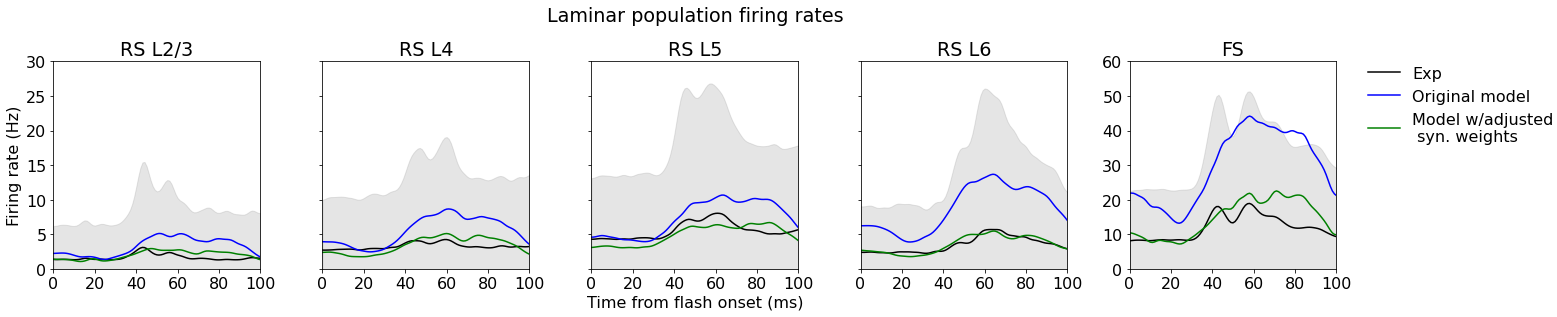

In [32]:
tstim_onset_exp = 1000

fig, axes = plt.subplots(ncols = 5, figsize = (22,4.5))

fig.subplots_adjust(wspace = 0.3, left = 0.04, right = 0.85, bottom = 0.18, top = 0.82)

sim_names = list(sims_spike_trains_layer_pops.keys())
sim_names = sim_names
print(sim_names)
#sim_names.insert(0, sim_names.pop())

iplot = 0
for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
    
    if iplot == 4:
        axes[iplot].set_ylim([0, 60])
    else:
        axes[iplot].set_ylim([0, 30])
        if iplot == 0:
            
            fir_rate_label = 'Exp'
            std_label = '±1$\sigma$'
            
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels(np.arange(0,30+5,5))
        else:
            fir_rate_label = None
            std_label = None
            sim_labels = [None, None]
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels([])
    
    pop_fir_rate = np.mean(np.mean(all_spike_trains_pop, axis = 0), axis = 0) * 1E3
    
    #all_spike_trains_pop_rs = all_spike_trains_pop.reshape(all_spike_trains_pop.shape[0]*\
    #                                                       all_spike_trains_pop.shape[1],-1)
    
    fir_rate_trial_avg = np.mean(all_spike_trains_pop, axis = 1)
    
    #std_time_resolved =  np.std(all_spike_trains_pop_rs, axis = 0)[tstim_onset:tstim_onset+100]*1E3
    
    std_of_trial_avg =  np.std(fir_rate_trial_avg, axis = 0)[tstim_onset_exp:tstim_onset_exp+105]*1E3
    
    std_of_trial_avg = gaussian_filter(std_of_trial_avg, sigma = 2)

    
    
    fir_rate_plot = gaussian_filter(pop_fir_rate, sigma = 2)[tstim_onset_exp:tstim_onset_exp+105]
    
    time = np.arange(0, 105, 1)
    
    axes[iplot].plot(time, fir_rate_plot, color = 'k', label = fir_rate_label)
    
    axes[iplot].fill_between(x = time, y1 = fir_rate_plot-std_of_trial_avg, \
                             y2 = fir_rate_plot+std_of_trial_avg, color = (0.5,0.5,0.5), 
                             alpha = 0.2)
    
    for isim, sim_name in enumerate(sim_names[::-1]):
        
        #if '19' not in sim_name:
        #    continue
        
        
        sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

        sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                    tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = 0)*1E3

        sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

        if iplot == 0:
            sim_label = sims_labels[sim_name]
            #sim_label = sim_name
        else:
            sim_label = None
        
        axes[iplot].plot(time, sim_fir_rate_plot, color = sims_colors[sim_name], label = sim_label)
        #axes[iplot].plot(time, sim_fir_rate_plot, label = sim_label)
    
    
            
    axes[iplot].set_xticks(np.arange(0,100+20,20))
    axes[iplot].set_xticklabels(np.arange(0,100+20,20))
    
    axes[iplot].set_xlim([0,100])
    
    axes[iplot].set_title(pop_name)
    iplot += 1
    
axes[0].set_ylabel('Firing rate (Hz)')

fig.suptitle('Laminar population firing rates', y = 0.99, x = 0.445)
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
axes[2].set_xlabel('Time from flash onset (ms)')
    
fig.legend(bbox_to_anchor = (0.99, 0.82), frameon = False)
print(sim_name)
fig_name = 'exp_and_sim_pop_fir_rate_'+sim_name+'.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

## Quantify effects of manipulating either synaptic weights or synaptic placement on CSD and spikes

### Load data from sims with synaptic position manipulation

In [60]:
sel_layer = '5'

In [61]:
nchan_sim = 23           # Number of channels on probe in simulation

trial_dur_sim = 750      # Duration one trial (ms)
tstim_onset_sim = 250    # Stimulus onset in each trial (ms)
ntrials_sim = 10         # Number of trials

step_depth_ticks_sim = 5
step_depth_ticklabels_sim = 200
nchan_sim = 23
depth_ticks_sim = np.arange(0, nchan_sim, step_depth_ticks_sim)
depth_ticklabels_sim = -np.arange(0, 1000, step_depth_ticklabels_sim, dtype = 'int')

step_time_ticks_sim = 20
time_tick_stop_sim = 100
time_tick_start_sim = 0
time_ticks_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)
time_ticklabels_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)

#### Load total csd

In [120]:
csd_manip_sims = dict()

selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
csd_sims = find_files(selected_sims_data_dir, filename = 'csd_total.npy')
for sim_name in list(csd_sims.keys()):
    if 'old' in sim_name:
        csd_manip_sims[sim_name] = csd_sims[sim_name]
    
selected_sims_data_dir = os.path.join(sim_data_dir, 'other_sims_fig5')
csd_sims = find_files(selected_sims_data_dir, filename = 'csd_total.npy')
for sim_name in list(csd_sims.keys()):
    csd_manip_sims[sim_name] = csd_sims[sim_name]
        
print('Total CSD from model versions: ', list(csd_manip_sims.keys()))

old_model
intermediate_model
final_model
all_syns_on_L5_basal_dend
all_syns_on_L4_apical_dend
all_syns_on_L23_apical_dend
all_syns_on_L23_basal_dend
all_syns_on_L5_apical_dend
all_syns_on_L5_200um
all_syns_on_L4_basal_dend
Total CSD from model versions:  ['old_model', 'all_syns_on_L5_basal_dend', 'all_syns_on_L4_apical_dend', 'all_syns_on_L23_apical_dend', 'all_syns_on_L23_basal_dend', 'all_syns_on_L5_apical_dend', 'all_syns_on_L5_200um', 'all_syns_on_L4_basal_dend']


### CSD contribution from population where syn placement was changed

In [63]:
csd_sims_layerpops_all = find_files(sim_data_dir, filename = 'csd_layerpop_contributions_summed.npy')

for sim_name in list(csd_sims_layerpops_all.keys()):
    if '5' not in sel_layer:
        if 'all_syns_on_L'+sel_layer not in sim_name and 'old_model' not in sim_name:
            del csd_sims_layerpops_all[sim_name]
    else:
        if 'all_syns_on_L'+sel_layer not in sim_name:
            del csd_sims_layerpops_all[sim_name]

print('Population CSD from model versions', list(csd_sims_layerpops_all.keys()))


final_model_turn_fb_off
final_model
inh_synapses_removed
old_model
intermediate_model
final_model
all_syns_on_L5_basal_dend
all_syns_on_L4_apical_dend
all_syns_on_L23_apical_dend
all_syns_on_L23_basal_dend
all_syns_on_L5_apical_dend
all_syns_on_L5_200um
all_syns_on_L4_basal_dend
Population CSD from model versions ['all_syns_on_L5_basal_dend', 'all_syns_on_L5_apical_dend', 'all_syns_on_L5_200um']


#### Make the csd dict holding simulations to compare equal to population contrib CSD from pop where syn placement was manipulated

In [64]:
csd_manip_sims = dict()
for sim_name in list(csd_sims_layerpops_all.keys()):
    csd_manip_sims[sim_name] = np.mean(csd_sims_layerpops_all[sim_name][sel_layer+'e'], axis = 0)

In [65]:
sel_layer = '5'

In [66]:
sims_labels_manip = dict()

sims_labels_manip['old_model'] = 'Original model'
sims_labels_manip['all_syns_on_L'+sel_layer+'_basal_dend'] = 'All synapses on \nbasal dendrites'
sims_labels_manip['all_syns_on_L'+sel_layer+'_apical_dend'] = 'All synapses on \napical dendrites'
sims_labels_manip['all_syns_on_L'+sel_layer+'_200um'] = 'Synapses on both apical\nand basal dendrites'

sims_colors_manip = dict()
sims_colors_manip['old_model'] = 'b'
sims_colors_manip['all_syns_on_L'+sel_layer+'_basal_dend'] = 'fuchsia'
sims_colors_manip['all_syns_on_L'+sel_layer+'_apical_dend'] = 'lime'
sims_colors_manip['all_syns_on_L'+sel_layer+'_200um'] = 'b'

#### Plot total CSD from simulations with original synaptic placement and simulations with synaptic placement onto L4 excitatory cells manipulated

In [70]:
csd_manip_sims[sim_name].shape

(26, 750)

all_syns_on_L5_basal_dend
all_syns_on_L5_apical_dend
all_syns_on_L5_200um


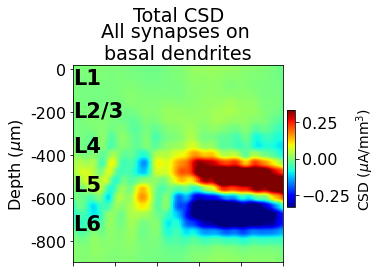

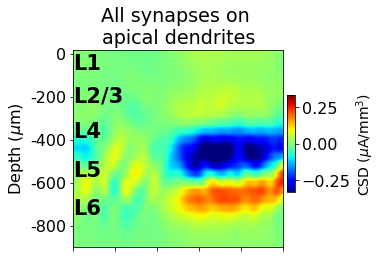

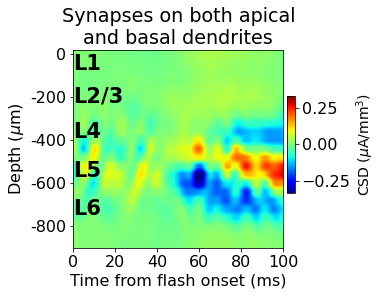

In [73]:
sims_csd_avg_amp = dict()

scale_to_uA = 1E-3
isim = 0
for sim_name in csd_manip_sims.keys():
    fig, ax = plt.subplots(1,1,figsize=(5.3,4.5), sharey = True)

    fig.subplots_adjust(wspace = 0.1, left = 0.2, right = 0.75, top = 0.74, bottom = 0.13)

    csd_plot = csd_manip_sims[sim_name][:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_uA
    print(sim_name)    
    ax.set_xlim([0,100])
    
    title = sims_labels_manip[sim_name]
    ax.set_title(title)
    
    if isim == 0:
        cmap_range = np.abs(csd_plot).max()/1.7
    im = ax.imshow(csd_plot[:23], cmap= 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

    ax.set_xticks(time_ticks_sim)
    
    if isim == 2:
        ax.set_xlabel('Time from flash onset (ms)')
    else:
        ax.set_xticklabels([])
    
    plt.figtext(x = 0.2, y = 0.68, s = 'L1', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.58, s = 'L2/3', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.47, s = 'L4', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.35, s = 'L5', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.2, y = 0.23, s = 'L6', fontsize = 21, fontweight = 560)
    
    ax.set_yticks(depth_ticks_sim)
    ax.set_yticklabels(depth_ticklabels_sim)

    ax.set_ylabel('Depth ($\mu$m)')
    if isim == 2:
        ax.set_xlabel('Time from flash onset (ms)')

    cbaxes = fig.add_axes([0.76,0.3,0.02, 0.3])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)', fontsize = 14)

    if isim == 0:
        fig.suptitle('Total CSD', y = 0.92, x = 0.475)

    fig_name = 'csd-total-e4-mods.png'

    savepath = os.path.join('Figures', 'Figure_5', fig_name)

    #fig.savefig(savepath, facecolor = 'w')
    
    isim += 1

### Load layerpop contributions to CSD

In [74]:
csd_sims_layerpops = find_files(selected_sims_data_dir, filename = 'csd_layerpop_contributions_summed.npy')

all_syns_on_L5_basal_dend
all_syns_on_L4_apical_dend
all_syns_on_L23_apical_dend
all_syns_on_L23_basal_dend
all_syns_on_L5_apical_dend
all_syns_on_L5_200um
all_syns_on_L4_basal_dend


In [75]:
csd_manip_layerpops_sims = dict()

if '5' not in sel_layer:
    selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
    csd_sims_layerpops  = find_files(selected_sims_data_dir, filename = 'csd_layerpop_contributions_summed.npy')
    for sim_name in list(csd_sims_layerpops .keys()):
        if 'old' in sim_name:
            csd_manip_layerpops_sims[sim_name] = csd_sims_layerpops [sim_name]
    
selected_sims_data_dir = os.path.join(sim_data_dir, 'other_sims_fig5')
csd_sims_layerpops = find_files(selected_sims_data_dir, filename = 'csd_layerpop_contributions_summed.npy')
for sim_name in list(csd_sims_layerpops.keys()):
    if sel_layer in sim_name:
        csd_manip_layerpops_sims[sim_name] = csd_sims_layerpops[sim_name]
        
print('Total CSD from model versions: ', list(csd_manip_layerpops_sims.keys()))

all_syns_on_L5_basal_dend
all_syns_on_L4_apical_dend
all_syns_on_L23_apical_dend
all_syns_on_L23_basal_dend
all_syns_on_L5_apical_dend
all_syns_on_L5_200um
all_syns_on_L4_basal_dend
Total CSD from model versions:  ['all_syns_on_L5_basal_dend', 'all_syns_on_L5_apical_dend', 'all_syns_on_L5_200um']


#### Plot contributions to the CSD from L2/3, L4, or L5 excitatory cells

In [76]:
sel_layer = '5'

all_syns_on_L5_200um
all_syns_on_L5_apical_dend
all_syns_on_L5_basal_dend


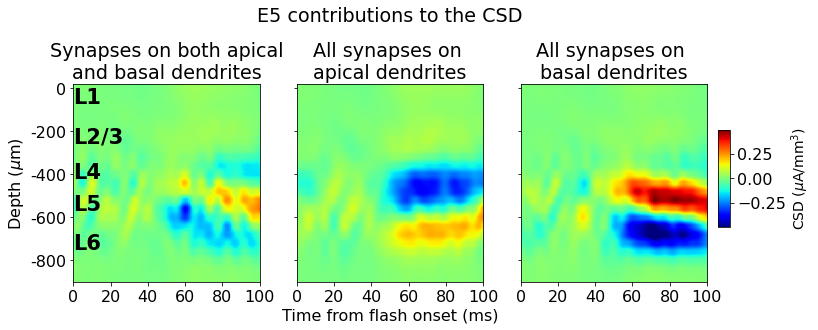

In [77]:
isim = 0

scale_to_uA = 1E-3

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(16,4.5), sharey = True, sharex = True)

fig.subplots_adjust(wspace = 0.2, left = 0.2, right = 0.75, top = 0.74, bottom = 0.13)

sims_csd_avg_amp = dict()
for isim, sim_name in enumerate(list(csd_manip_layerpops_sims.keys())[::-1]):
    icol = isim % 3
    
    ax = axes[icol]

    csd_sim_layerpops = csd_manip_layerpops_sims[sim_name]
    print(sim_name)
    csd_plot = csd_sim_layerpops[sel_layer+'e'][:, :, tstim_onset_sim:tstim_onset_sim+101]*scale_to_uA
    csd_plot = np.mean(csd_plot, axis = 0)
    
    title = sims_labels_manip[sim_name]
    ax.set_title(title)
    ax.set_xlim([0,100])
    
    if isim == 0:
        cmap_range = np.abs(csd_plot).max()*1.3
        ax.set_ylabel('Depth ($\mu$m)')
    #cmap_range = cmap_ranges[sim_name]
    im = ax.imshow(csd_plot[:23], cmap= 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
    
    ax.set_xticks(time_ticks_sim)
    if isim == 1:
        ax.set_xlabel('Time from flash onset (ms)')
    
ax.set_yticks(depth_ticks_sim)
ax.set_yticklabels(depth_ticklabels_sim)


#plt.figtext(s = 'Time from flash onset (ms)', x = 0.35, y = 0.05)

cbaxes = fig.add_axes([0.76,0.3,0.01, 0.3])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)', fontsize = 14)

plt.figtext(x = 0.2, y = 0.68, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.2, y = 0.56, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.2, y = 0.45, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.2, y = 0.35, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.2, y = 0.23, s = 'L6', fontsize = 21, fontweight = 560)

fig.suptitle('E'+sel_layer+' contributions to the CSD', y = 0.98, x = 0.475)


fig_name = 'csd-E'+sel_layer+'-'+sim_name+'-v2.png'

savepath = os.path.join('Figures', 'Supplementary_figures', 'syn_placement_manip', fig_name)

#fig.savefig(savepath, facecolor = 'w')


#### Spikes

In [80]:
sel_layer = '5'

In [81]:
timestamps_configs = dict()

if '5' not in sel_layer:

    selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
    timestamps_configs_temp = find_all_fir_rates_files_sim(selected_sims_data_dir, 'timestamps_with_neuron_ids.npy')

    for sim_name in list(timestamps_configs_temp.keys()):
        if 'old' in sim_name:
            timestamps_configs[sim_name] = timestamps_configs_temp[sim_name]

selected_sims_data_dir = os.path.join(sim_data_dir, 'other_sims_fig5')
timestamps_configs_temp = find_all_fir_rates_files_sim(selected_sims_data_dir, 'timestamps_with_neuron_ids.npy')

for sim_name in list(timestamps_configs_temp.keys()):
    if 'L'+sel_layer in sim_name:
        timestamps_configs[sim_name] = timestamps_configs_temp[sim_name]

sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]


['all_syns_on_L5_basal_dend', 'all_syns_on_L5_apical_dend', 'all_syns_on_L5_200um']


In [82]:
sims_spike_trains_cell_pops = dict()
for sim_name in sorted(list(timestamps_configs.keys())):
    print(sim_name)

    timestamps_all_cell_pops = timestamps_configs[sim_name]
    cell_names = list(timestamps_all_cell_pops.keys())


    sim_spike_trains_cell_pops = dict()

    for cell_name in cell_names:
        print(cell_name)
        timestamps_cell_pop = timestamps_all_cell_pops[cell_name]

        neuron_ids = timestamps_cell_pop['neuron_ids_of_timestamps']
        trials = timestamps_cell_pop['trials']
        timestamps = timestamps_cell_pop['timestamps']
        #timestamps = timestamps_cell_pop['timestamps_by_trial']
        trial_dur_sim = timestamps_cell_pop['trial_dur']
        #ntrials_sim = len(np.unique(trials))
        '''TODO: Implement general way to determine # of trials (that also works for sims that lasted a bit too long)'''
        ntrials_sim = 10
        #ntrials_sim = 3
        #ntrials_sim = 7
        #ntrials_sim = len(np.unique(trials))
        #print(ntrials_sim)
        timestamps = timestamps % trial_dur_sim
        all_neuron_ids = timestamps_cell_pop['all_neuron_ids_in_pop']

        spike_trains = np.zeros((len(all_neuron_ids), ntrials_sim, trial_dur_sim))
        bins = np.arange(0,trial_dur_sim+1,1)

        for i_nrn, neuron_id in enumerate(all_neuron_ids):
            mask_neuron_id = neuron_ids == neuron_id

            timestamps_nrn = timestamps[mask_neuron_id]

            trials_this_nrn = trials[mask_neuron_id]

            for trial in np.unique(trials_this_nrn):
                if trial >= ntrials_sim:
                    continue
                mask_trial = trials_this_nrn == trial
                timestamps_nrn_this_trial = timestamps_nrn[mask_trial]
                spike_train_trial, _ = np.histogram(timestamps_nrn_this_trial, bins)

                spike_trains[i_nrn, int(trial)] = spike_train_trial

        sim_spike_trains_cell_pops[cell_name] = spike_trains[:,:ntrials_sim]
        
    sims_spike_trains_cell_pops[sim_name] = sim_spike_trains_cell_pops

all_syns_on_L5_200um
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
all_syns_on_L5_apical_dend
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
all_syns_on_L5_basal_dend
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [83]:
sims_spike_trains_layer_pops = dict()

for sim_name in sims_spike_trains_cell_pops.keys():

    sim_spike_trains_layer_pops = dict()
    
    sim_spike_trains_layer_pops['E'+sel_layer] = []

    for cell_pop_name, sim_spike_trains_cell_pop in sims_spike_trains_cell_pops[sim_name].items():
        #print(cell_pop_name)#, sim_spike_trains_cell_pops[cell_pop_name].shape)
        if cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[:2] == 'e'+sel_layer[:1]:
            print(cell_pop_name)
            if len(sim_spike_trains_layer_pops['E'+sel_layer]) == 0:
                sim_spike_trains_layer_pops['E'+sel_layer] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['E'+sel_layer] = np.concatenate((sim_spike_trains_layer_pops['E'+sel_layer], 
                                                               sim_spike_trains_cell_pop), axis = 0)                
                
    sims_spike_trains_layer_pops[sim_name] = sim_spike_trains_layer_pops

e5Rbp4
e5noRbp4
e5Rbp4
e5noRbp4
e5Rbp4
e5noRbp4


In [84]:
sims_spike_trains_layer_pops.keys()

dict_keys(['all_syns_on_L5_200um', 'all_syns_on_L5_apical_dend', 'all_syns_on_L5_basal_dend'])

In [85]:
sel_layer = '5'

In [86]:
sims_spike_trains_layer_pops_temp = dict()

sims_spike_trains_layer_pops_temp['all_syns_on_L5_200um'] = sims_spike_trains_layer_pops['all_syns_on_L5_200um']
sims_spike_trains_layer_pops_temp['all_syns_on_L5_basal_dend'] = sims_spike_trains_layer_pops['all_syns_on_L5_basal_dend']
sims_spike_trains_layer_pops_temp['all_syns_on_L5_apical_dend'] = sims_spike_trains_layer_pops['all_syns_on_L5_apical_dend']

sims_spike_trains_layer_pops = sims_spike_trains_layer_pops_temp

sims_spike_trains_layer_pops.keys()

dict_keys(['all_syns_on_L5_200um', 'all_syns_on_L5_basal_dend', 'all_syns_on_L5_apical_dend'])

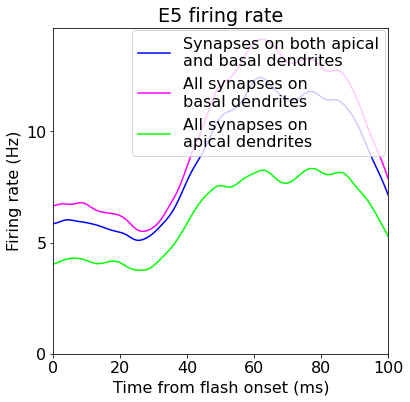

In [87]:
fig, axes = plt.subplots(ncols = 1, figsize = (6,6))

iplot = 0

pop_name = 'E'+sel_layer

sims_E4_fir_rate = dict()
sims_E4_spike_trains = dict()

time = np.arange(0, 105, 1)
for isim, sim_name in enumerate(list(sims_spike_trains_layer_pops.keys())):
    #if '11' not in sim_name and '12' not in sim_name:
    #    continue


    sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

    sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = 0)*1E3

    sims_E4_fir_rate[sim_name] = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = -1)*1E3
    
    sims_E4_spike_trains[sim_name] = sim_spike_trains_layer_pop

    sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

    if iplot == 0:
        sim_label = sims_labels_manip[sim_name]
    else:
        sim_label = None

    axes.plot(time, sim_fir_rate_plot, color = sims_colors_manip[sim_name], label = sim_label)

axes.margins(x=0)

axes.set_yticks(np.arange(0,10+5,5))
axes.set_yticklabels(np.arange(0,10+5,5))    

#axes.set_xticks(np.arange(0,100+20,20))
#axes.set_xticklabels(np.arange(0,100+20,20))
axes.set_xlim([0,100])

iplot += 1
    
axes.set_title('E'+sel_layer+' firing rate')
    
axes.set_ylabel('Firing rate (Hz)')
axes.set_xlabel('Time from flash onset (ms)')
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
    
fig.legend(bbox_to_anchor = (0.91, 0.88))

fig_name = 'E'+sel_layer+'-firing-rate-diff-syn-placement.png'

savepath = os.path.join('Figures', 'Supplementary_figures', 'syn_placement_manip', fig_name)

#fig.savefig(savepath, facecolor = 'w')

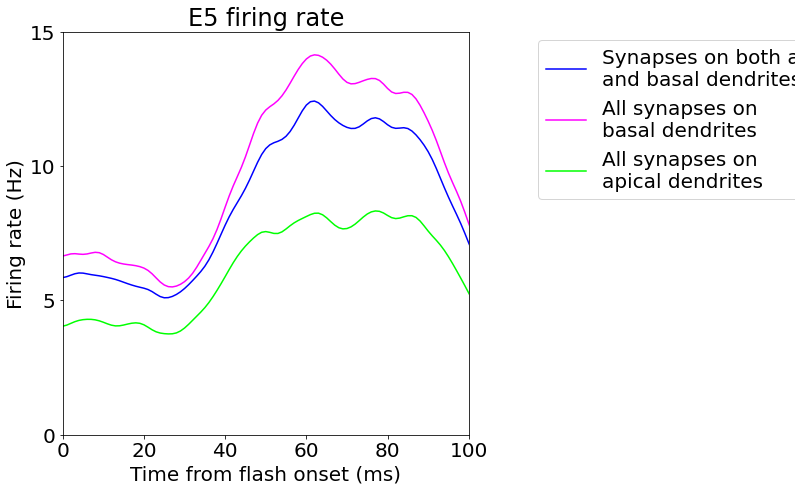

In [88]:
plt.rcParams.update({'font.size': 20})

fig, axes = plt.subplots(ncols = 1, figsize = (12,8))

iplot = 0

pop_name = 'E'+sel_layer

sims_E4_fir_rate = dict()
sims_E4_spike_trains = dict()

time = np.arange(0, 105, 1)
for isim, sim_name in enumerate(list(sims_spike_trains_layer_pops.keys())):
    #if '11' not in sim_name and '12' not in sim_name:
    #    continue


    sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

    sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = 0)*1E3

    sims_E4_fir_rate[sim_name] = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = -1)*1E3
    
    sims_E4_spike_trains[sim_name] = sim_spike_trains_layer_pop

    sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

    if iplot == 0:
        sim_label = sims_labels_manip[sim_name]
    else:
        sim_label = None

    axes.plot(time, sim_fir_rate_plot, color = sims_colors_manip[sim_name], label = sim_label)

axes.set_xlim([0,100])

axes.set_xticks(np.arange(0,120,20))
axes.set_xticklabels(np.arange(0,120,20))

axes.set_yticks(np.arange(0,15+5,5))
axes.set_yticklabels(np.arange(0,15+5,5))    

#axes.set_xticks(np.arange(0,100+20,20))
#axes.set_xticklabels(np.arange(0,100+20,20))

#axes.set_xlim([0,100])

iplot += 1
    
axes.set_title('E'+sel_layer+' firing rate')
    
axes.set_ylabel('Firing rate (Hz)')
axes.set_xlabel('Time from flash onset (ms)')

axes.margins(x=0)
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)

fig.subplots_adjust(left = 0.15, right = 0.62, bottom = 0.15, top = 0.85)
    
fig.legend(bbox_to_anchor = (1.001, 0.8))

fig_name = 'E'+sel_layer+'-firing-rate-diff-syn-placement.png'

savepath = os.path.join('Figures', 'Supplementary_figures', 'syn_placement_manip', fig_name)

#fig.savefig(savepath, facecolor = 'w')

plt.rcParams.update({'font.size': 16})

In [89]:
sel_layer

'5'

# Quantitatively verify change in firing rate minor with change in synaptic placement

### Spike dynamics

#### KS similarity

In [90]:
pop_name = 'RS L'+sel_layer
tstim_onset_exp = 1000

exp_ks_simil_pairwise_modes = dict()

for mode in ['peak', 'baseline', 'post-peak']:

    #print(mode)

    if mode == 'peak':
        t_start_exp = tstim_onset_exp+35
        t_stop_exp = tstim_onset_exp+60
    elif mode == 'baseline':
        t_start_exp = 500
        t_stop_exp = tstim_onset_exp
    elif mode == 'post-peak':
        t_start_exp = tstim_onset_exp+60
        t_stop_exp = tstim_onset_exp+100

    exp_ks_simil_pairwise = dict()
    for isess1, session_id1 in enumerate(sessions_spike_trains_layer_pops.keys()):
        if sessions_spike_trains_layer_pops[session_id1][pop_name].shape[0] < 10:
            continue

        session1_fir_rates_RS_L4 = np.mean(np.mean(sessions_spike_trains_layer_pops[session_id1][pop_name]\
                                           [:,:,t_start_exp:t_stop_exp], axis = -1), axis = -1)
        
        for isess2 in range(isess1+1, len(sessions_spike_trains_layer_pops.keys())):
            session_id2 = list(sessions_spike_trains_layer_pops.keys())[isess2]
            if sessions_spike_trains_layer_pops[session_id2][pop_name].shape[0] < 10:
                continue
                
            session2_fir_rates_RS_L4 = np.mean(np.mean(sessions_spike_trains_layer_pops[session_id2][pop_name]\
                                           [:,:,t_start_exp:t_stop_exp], axis = -1), axis = -1)
        
        
            ks_dist = stats.ks_2samp(session1_fir_rates_RS_L4, session2_fir_rates_RS_L4)[0]

            ks_simil_temp = 1-ks_dist
                            
            exp_ks_simil_pairwise[str(session_id1)+'_'+str(session_id2)] = ks_simil_temp
                            
    exp_ks_simil_pairwise_modes[mode] = exp_ks_simil_pairwise

In [181]:
sims_E4_spike_trains.keys()

dict_keys(['all_syns_on_L5_200um', 'all_syns_on_L5_basal_dend', 'all_syns_on_L5_apical_dend'])

In [92]:


sims_ks_simil_pairwise_modes = dict()

for mode in ['peak', 'baseline', 'post-peak']:

    #print(mode)

    if mode == 'peak':
        t_start_sim = tstim_onset_sim+35
        t_stop_sim = tstim_onset_sim+60
    elif mode == 'baseline':
        t_start_sim = 0
        t_stop_sim = tstim_onset_sim
    elif mode == 'post-peak':
        t_start_sim = tstim_onset_sim+60
        t_stop_sim = tstim_onset_sim+100

    sims_ks_simil_pairwise = dict()
    
    
    for isim1, sim_name1 in enumerate(list(sims_E4_spike_trains.keys())):
        #fig, axes = plt.subplots(nrows = 2, figsize = (5,10))
        for isim2 in range(isim1+1, len(sims_E4_spike_trains.keys())):
            sim_name2 = list(sims_E4_spike_trains.keys())[isim2]
            
            print(sim_name1, sim_name2)
        
            sim1_E4_fir_rate = np.mean(np.mean(sims_E4_spike_trains[sim_name1][:,:,t_start_sim:t_stop_sim], axis = -1), axis = -1)
            sim2_E4_fir_rate = np.mean(np.mean(sims_E4_spike_trains[sim_name2][:,:,t_start_sim:t_stop_sim], axis = -1), axis = -1)
            
            #axes[0].plot(np.mean(np.mean(sims_E4_spike_trains[sim_name1][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 0), axis = 0), label = sim_name1)
            #axes[0].plot(np.mean(np.mean(sims_E4_spike_trains[sim_name2][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 0), axis = 0), label = sim_name2)
            #axes[0].legend(bbox_to_anchor = (1,0.5))
            
            ks_dist = stats.ks_2samp(sim1_E4_fir_rate, sim2_E4_fir_rate)[0]

            ks_simil_temp = 1-ks_dist

            print(mode, ks_simil_temp)
            
            sims_ks_simil_pairwise[sim_name1+'-'+sim_name2] = ks_simil_temp
            
            #axes[1].plot(sim1_E4_fir_rate)
            #axes[1].plot(sim2_E4_fir_rate)
            
            
    sims_ks_simil_pairwise_modes[mode] = sims_ks_simil_pairwise
    #plt.figure()
    #plt.plot(np.cumsum(sim1_E4_fir_rate)/np.cumsum(sim1_E4_fir_rate).max())
    #plt.plot(np.cumsum(sim2_E4_fir_rate)/np.cumsum(sim2_E4_fir_rate).max())

all_syns_on_L5_200um all_syns_on_L5_basal_dend
peak 0.9505879244285903
all_syns_on_L5_200um all_syns_on_L5_apical_dend
peak 0.8526885982296208
all_syns_on_L5_basal_dend all_syns_on_L5_apical_dend
peak 0.8246796142158805
all_syns_on_L5_200um all_syns_on_L5_basal_dend
baseline 0.9417360285374554
all_syns_on_L5_200um all_syns_on_L5_apical_dend
baseline 0.847668119963007
all_syns_on_L5_basal_dend all_syns_on_L5_apical_dend
baseline 0.7964063945038975
all_syns_on_L5_200um all_syns_on_L5_basal_dend
post-peak 0.9483419209935262
all_syns_on_L5_200um all_syns_on_L5_apical_dend
post-peak 0.8669573259347338
all_syns_on_L5_basal_dend all_syns_on_L5_apical_dend
post-peak 0.8219051393843309


In [97]:
sim_names

['all_syns_on_L5_basal_dend',
 'all_syns_on_L5_apical_dend',
 'all_syns_on_L5_200um']

In [98]:
sims_diff_manip_labels = dict()

if '5' in sel_layer:
    sims_diff_manip_labels['all_syns_on_L5_200um-all_syns_on_L'+sel_layer+'_basal_dend'] = 'Between original model config.\nand model w/all exc. synapses\non L'+sel_layer+' basal dendrites'
    sims_diff_manip_labels['all_syns_on_L5_200um-all_syns_on_L'+sel_layer+'_apical_dend'] = 'Between original model config.\nand model w/all exc. synapses\non L'+sel_layer+' apical dendrites'
    sims_diff_manip_labels['all_syns_on_L'+sel_layer+'_basal_dend-all_syns_on_L'+sel_layer+'_apical_dend'] =  'Between model w/all exc.\nsynapses on L'+sel_layer+' basal dendrites\nand model w/all exc.\nsynapses on L'+sel_layer+' apical dendrites'
elif '2' in sel_layer or '4' in sel_layer:
    sims_diff_manip_labels['old_model-all_syns_on_L'+sel_layer+'_basal_dend'] = 'Between original model and\nmodel w/all exc. synapses\non L'+sel_layer+' basal dendrites'
    sims_diff_manip_labels['old_model-all_syns_on_L'+sel_layer+'_apical_dend'] = 'Between original model and\nmodel w/all exc. synapses\non L'+sel_layer+' apical dendrites'
    sims_diff_manip_labels['all_syns_on_L'+sel_layer+'_basal_dend-all_syns_on_L'+sel_layer+'_apical_dend'] =  'Between model w/all exc.\nsynapses on L'+sel_layer+' basal dendrites\nand model w/all exc.\nsynapses on L'+sel_layer+' apical dendrites'    
    
sims_diff_manip_colors = dict()
if '5' in sel_layer:
    sims_diff_manip_colors['all_syns_on_L5_200um-all_syns_on_L'+sel_layer+'_basal_dend'] = '#10314a'
    sims_diff_manip_colors['all_syns_on_L5_200um-all_syns_on_L'+sel_layer+'_apical_dend'] = '#ffbd41'
    sims_diff_manip_colors['all_syns_on_L'+sel_layer+'_basal_dend-all_syns_on_L'+sel_layer+'_apical_dend'] = 'blueviolet'
elif '2' in sel_layer or '4' in sel_layer:
    sims_diff_manip_colors['old_model-all_syns_on_L'+sel_layer+'_basal_dend'] = '#10314a'
    sims_diff_manip_colors['old_model-all_syns_on_L'+sel_layer+'_apical_dend'] = '#ffbd41'
    sims_diff_manip_colors['all_syns_on_L'+sel_layer+'_basal_dend-all_syns_on_L'+sel_layer+'_apical_dend'] = 'blueviolet'

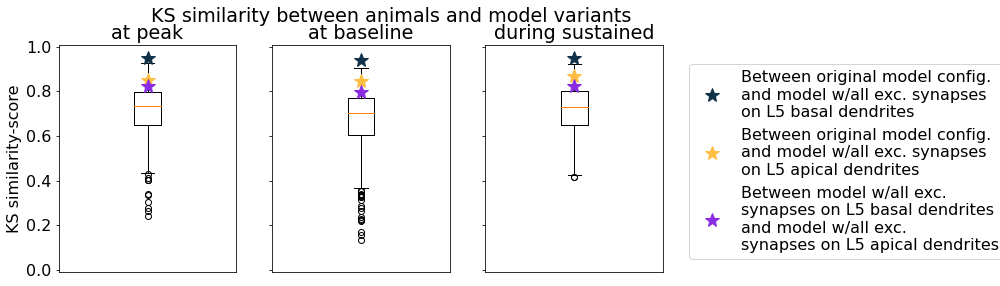

In [99]:
fig, axes = plt.subplots(ncols = 3, figsize = (14, 4.), sharey = True)

fig.subplots_adjust(left = 0.07, right = 0.67, bottom = 0.06, top = 0.85)

for imode, mode in enumerate(exp_ks_simil_pairwise_modes.keys()):
    ax = axes[imode]
    exp_ks_simil_pairwise_mode = np.array(list(exp_ks_simil_pairwise_modes[mode].values()))
    
    ax.boxplot(exp_ks_simil_pairwise_mode)
    
    sims_ks_simil_pairwise = sims_ks_simil_pairwise_modes[mode]
    
    for i, sim_names in enumerate(sims_ks_simil_pairwise.keys()):
        sim_name1, sim_name2 = sim_names.split('-')
        
        sims_ks_simil = sims_ks_simil_pairwise[sim_names]
        
        if imode == 2:
            sims_label = sims_diff_manip_labels[sim_names]
        else:
            sims_label = None
    
        ax.plot(1, sims_ks_simil, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
        
    if imode == 0:
        ax.set_ylabel('KS similarity-score')
        
    ax.set_xticks([])
    
    if mode == 'baseline':
        mode_title = 'at baseline'
    elif mode == 'peak':
        mode_title = 'at peak'
    elif mode == 'post-peak':
        mode_title = 'during sustained'
    
    ax.set_title(mode_title)
    
ax.set_ylim([-0.01, 1.01])
fig.legend(bbox_to_anchor = (1.005, 0.8))

fig.suptitle('KS similarity between animals and model variants', x = 0.4)

fig_name = 'KS-similarity-model-syn-manips-and-pairwise-exp-E'+sel_layer+'.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w', bbox_to_inches = 'tight')

### Correlation

- Modify next two cells

In [100]:
pop_name = 'RS L'+sel_layer
tstim_onset_exp = 1000

exp_corr_pairwise = dict()


for isess1, session_id1 in enumerate(sessions_spike_trains_layer_pops.keys()):
    if sessions_spike_trains_layer_pops[session_id1][pop_name].shape[0] < 10:
        continue

    session1_fir_rates_RS_L4 = np.mean(np.mean(sessions_spike_trains_layer_pops[session_id1][pop_name]\
                                       [:,:,tstim_onset_exp:tstim_onset_exp+100], axis = 0), axis = 0)

    for isess2 in range(isess1+1, len(sessions_spike_trains_layer_pops.keys())):
        session_id2 = list(sessions_spike_trains_layer_pops.keys())[isess2]
        if sessions_spike_trains_layer_pops[session_id2][pop_name].shape[0] < 10:
            continue

        session2_fir_rates_RS_L4 = np.mean(np.mean(sessions_spike_trains_layer_pops[session_id2][pop_name]\
                                       [:,:,tstim_onset_exp:tstim_onset_exp+100], axis = 0), axis = 0)
        
        corr = stats.pearsonr(session1_fir_rates_RS_L4, session2_fir_rates_RS_L4)[0]

        exp_corr_pairwise[str(session_id1)+'_'+str(session_id2)] = corr

In [101]:
sims_corr_pairwise = dict()


for isim1, sim_name1 in enumerate(sims_E4_spike_trains.keys()):
    for isim2 in range(isim1+1, len(sims_E4_spike_trains.keys())):
        sim_name2 = list(sims_E4_spike_trains.keys())[isim2]
            
        print(sim_name1, sim_name2)
        
        sim1_E4_fir_rate = np.mean(np.mean(sims_E4_spike_trains[sim_name1][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 0), axis = 0)
        sim2_E4_fir_rate = np.mean(np.mean(sims_E4_spike_trains[sim_name2][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 0), axis = 0)
            
        corr = stats.pearsonr(sim1_E4_fir_rate, sim2_E4_fir_rate)[0]
            
        sims_corr_pairwise[sim_name1+'-'+sim_name2] = corr

all_syns_on_L5_200um all_syns_on_L5_basal_dend
all_syns_on_L5_200um all_syns_on_L5_apical_dend
all_syns_on_L5_basal_dend all_syns_on_L5_apical_dend


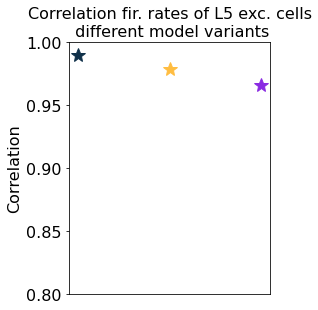

In [102]:
fig, ax = plt.subplots(figsize = (8,5))

fig.subplots_adjust(left = 0.15, right = 0.5, bottom = 0.15, top = 0.85)

for i, sim_names in enumerate(sims_corr_pairwise.keys()):
    sim_name1, sim_name2 = sim_names.split('-')

    sims_corr = sims_corr_pairwise[sim_names]

    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(i,sims_corr, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_ylim([0.8,1])

ax.set_xticks([])

#ax.legend(bbox_to_anchor = (1,1))

ax.set_ylabel('Correlation')

ax.set_title('Correlation fir. rates of L'+sel_layer+' exc. cells\n different model variants', fontsize = 16)

fig_name = 'corr_model_variants_diff_syn_placement_E'+sel_layer+'.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

In [103]:
fig_dir

'Figures/Supplementary_figures/quant_ver_fig5'

### Moments of peak magnitude and latency

In [104]:
pop_name = 'RS L'+sel_layer
tstim_onset_exp = 1000

sessions_diff_peak_fir_rate = dict()
sessions_diff_2nd_mom_peak = dict()
sessions_diff_3rd_mom_peak = dict()
sessions_diff_4th_mom_peak = dict()

sessions_diff_peak_latencies = dict()
sessions_diff_2nd_mom_lat = dict()
sessions_diff_3rd_mom_lat = dict()
sessions_diff_4th_mom_lat = dict()

for isess1, session_id1 in enumerate(sessions_spike_trains_layer_pops.keys()):
    if sessions_spike_trains_layer_pops[session_id1][pop_name].shape[0] < 10:
        continue

    session1_fir_rates_RS_L4 = gaussian_filter(np.mean(sessions_spike_trains_layer_pops[session_id1][pop_name]\
                                       [:,:,tstim_onset_exp:tstim_onset_exp+100], axis = 1), sigma = (0, 2))
    
    session1_peak_fir_rate_RS_L4 = np.max(session1_fir_rates_RS_L4, axis = -1)
    
    session1_peak_lat_RS_L4 = np.argmax(session1_fir_rates_RS_L4, axis = -1)

    for isess2 in range(isess1+1, len(sessions_spike_trains_layer_pops.keys())):
        session_id2 = list(sessions_spike_trains_layer_pops.keys())[isess2]
        if sessions_spike_trains_layer_pops[session_id2][pop_name].shape[0] < 10:
            continue
            
        session2_fir_rates_RS_L4 = gaussian_filter(np.mean(sessions_spike_trains_layer_pops[session_id2][pop_name]\
                                       [:,:,tstim_onset_exp:tstim_onset_exp+100], axis = 1), sigma = (0, 2))
        
        session2_peak_fir_rate_RS_L4 = np.max(session2_fir_rates_RS_L4, axis = -1)
        
        session2_peak_lat_RS_L4 = np.argmax(session2_fir_rates_RS_L4, axis = -1)
        
        diff_peak_fir_rate_RS_L4 = np.mean(session1_peak_fir_rate_RS_L4) - np.mean(session2_peak_fir_rate_RS_L4)
        diff_2nd_mom_peak_RS_L4 = np.std(session1_peak_fir_rate_RS_L4) - np.std(session2_peak_fir_rate_RS_L4)
        diff_3rd_mom_peak_RS_L4 = skew(session1_peak_fir_rate_RS_L4) - skew(session2_peak_fir_rate_RS_L4)
        diff_4th_mom_peak_RS_L4 = kurtosis(session1_peak_fir_rate_RS_L4) - kurtosis(session2_peak_fir_rate_RS_L4)
        
        sessions_diff_peak_fir_rate[str(session_id1)+'-'+str(session_id2)] = diff_peak_fir_rate_RS_L4
        sessions_diff_2nd_mom_peak[str(session_id1)+'-'+str(session_id2)] = diff_2nd_mom_peak_RS_L4
        sessions_diff_3rd_mom_peak[str(session_id1)+'-'+str(session_id2)] = diff_3rd_mom_peak_RS_L4
        sessions_diff_4th_mom_peak[str(session_id1)+'-'+str(session_id2)] = diff_4th_mom_peak_RS_L4
        

        diff_peak_lat_RS_L4 = np.mean(session1_peak_lat_RS_L4) - np.mean(session2_peak_lat_RS_L4)
        diff_2nd_mom_lat_RS_L4 = np.std(session1_peak_lat_RS_L4) - np.std(session2_peak_lat_RS_L4)
        diff_3rd_mom_lat_RS_L4 = skew(session1_peak_lat_RS_L4) - skew(session2_peak_lat_RS_L4)
        diff_4th_mom_lat_RS_L4 = kurtosis(session1_peak_lat_RS_L4) - kurtosis(session2_peak_lat_RS_L4)
        
        sessions_diff_peak_latencies[str(session_id1)+'-'+str(session_id2)] = diff_peak_lat_RS_L4
        sessions_diff_2nd_mom_lat[str(session_id1)+'-'+str(session_id2)] = diff_2nd_mom_lat_RS_L4
        sessions_diff_3rd_mom_lat[str(session_id1)+'-'+str(session_id2)] = diff_3rd_mom_lat_RS_L4
        sessions_diff_4th_mom_lat[str(session_id1)+'-'+str(session_id2)] = diff_4th_mom_lat_RS_L4
        

In [105]:
sims_E4_spike_trains.keys()

dict_keys(['all_syns_on_L5_200um', 'all_syns_on_L5_basal_dend', 'all_syns_on_L5_apical_dend'])

In [106]:
sims_diff_peak_fir_rate = dict()
sims_diff_2nd_mom_peak = dict()
sims_diff_3rd_mom_peak = dict()
sims_diff_4th_mom_peak = dict()

sims_diff_peak_latencies = dict()
sims_diff_2nd_mom_lat = dict()
sims_diff_3rd_mom_lat = dict()
sims_diff_4th_mom_lat = dict()
for isim1, sim_name1 in enumerate(list(sims_E4_spike_trains.keys())):
    for isim2 in range(isim1+1, len(sims_E4_spike_trains.keys())):
        sim_name2 = list(sims_E4_spike_trains.keys())[isim2]
            
        print(sim_name1, sim_name2)
        
        sim1_E4_fir_rate = gaussian_filter(np.mean(sims_E4_spike_trains[sim_name1][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 1), \
                                           sigma = (0,2))
        sim2_E4_fir_rate = gaussian_filter(np.mean(sims_E4_spike_trains[sim_name2][:,:,tstim_onset_sim:tstim_onset_sim+100], axis = 1), \
                                           sigma = (0,2))
        
        sim1_E4_peak_fir_rate = np.max(sim1_E4_fir_rate, axis = 1)
        sim2_E4_peak_fir_rate = np.max(sim2_E4_fir_rate, axis = 1)
        
        print(sim_name1, sim_name2, np.round(np.mean(sim1_E4_peak_fir_rate),2), np.round(np.mean(sim2_E4_peak_fir_rate), 2))
        
        diff_peak_fir_rate_sims = np.mean(sim1_E4_peak_fir_rate) - np.mean(sim2_E4_peak_fir_rate)
        diff_2nd_mom_peak_fir_rate_sims = np.var(sim1_E4_peak_fir_rate) - np.var(sim2_E4_peak_fir_rate)
        diff_3rd_mom_peak_fir_rate_sims = skew(sim1_E4_peak_fir_rate) - skew(sim2_E4_peak_fir_rate)
        diff_4th_mom_peak_fir_rate_sims = kurtosis(sim1_E4_peak_fir_rate) - kurtosis(sim2_E4_peak_fir_rate)
        
        sims_diff_peak_fir_rate[str(sim_name1)+'-'+str(sim_name2)] = diff_peak_fir_rate_sims
        sims_diff_2nd_mom_peak[str(sim_name1)+'-'+str(sim_name2)] = diff_2nd_mom_peak_fir_rate_sims
        sims_diff_3rd_mom_peak[str(sim_name1)+'-'+str(sim_name2)] = diff_3rd_mom_peak_fir_rate_sims
        sims_diff_4th_mom_peak[str(sim_name1)+'-'+str(sim_name2)] = diff_4th_mom_peak_fir_rate_sims
        
        sim1_E4_peak_lat = np.argmax(sim1_E4_fir_rate, axis = 1)
        sim2_E4_peak_lat = np.argmax(sim2_E4_fir_rate, axis = 1)

        diff_peak_lat_sims = np.mean(sim1_E4_peak_lat) - np.mean(sim2_E4_peak_lat)
        diff_2nd_mom_lat = np.std(sim1_E4_peak_lat) - np.std(sim2_E4_peak_lat)
        diff_3rd_mom_lat = skew(sim1_E4_peak_lat) - skew(sim1_E4_peak_lat)
        diff_4th_mom_lat = kurtosis(sim1_E4_peak_lat) - kurtosis(sim1_E4_peak_lat)
        
        sims_diff_peak_latencies[str(sim_name1)+'-'+str(sim_name2)] = diff_peak_lat_sims
        sims_diff_2nd_mom_lat[str(sim_name1)+'-'+str(sim_name2)] = diff_2nd_mom_lat
        sims_diff_3rd_mom_lat[str(sim_name1)+'-'+str(sim_name2)] = diff_3rd_mom_lat
        sims_diff_4th_mom_lat[str(sim_name1)+'-'+str(sim_name2)] = diff_4th_mom_lat

all_syns_on_L5_200um all_syns_on_L5_basal_dend
all_syns_on_L5_200um all_syns_on_L5_basal_dend 0.04 0.04
all_syns_on_L5_200um all_syns_on_L5_apical_dend
all_syns_on_L5_200um all_syns_on_L5_apical_dend 0.04 0.03
all_syns_on_L5_basal_dend all_syns_on_L5_apical_dend
all_syns_on_L5_basal_dend all_syns_on_L5_apical_dend 0.04 0.03


- Difference peak magnitude plot

In [107]:
sim_names

'all_syns_on_L5_basal_dend-all_syns_on_L5_apical_dend'

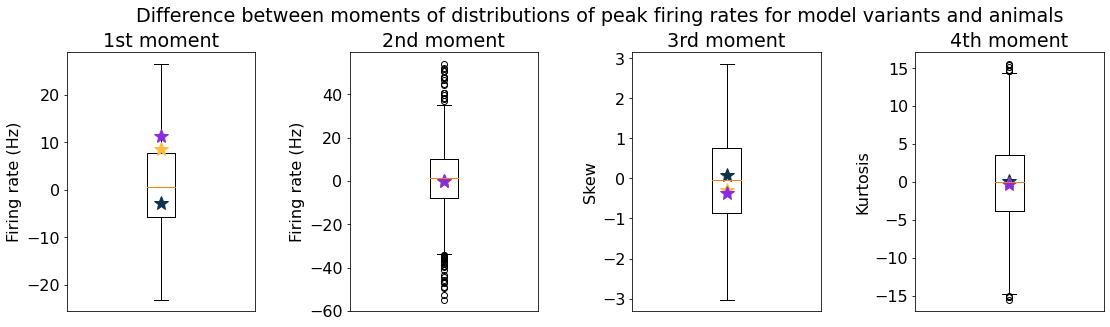

In [108]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4.5), sharex = True)

fig.subplots_adjust(wspace = 0.5, left = 0.05, right = 0.77, bottom = 0.05, top = 0.85)

ax = axes[0]
ax.boxplot(np.array(list(sessions_diff_peak_fir_rate.values()))*1E3)

for sim_names in sims_diff_peak_fir_rate.keys():
    diff_peak_fir_rate = sims_diff_peak_fir_rate[sim_names]*1E3
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_peak_fir_rate, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('1st moment')
    
ax = axes[1]
ax.boxplot(np.array(list(sessions_diff_2nd_mom_peak.values()))*1E3)
for sim_names in sims_diff_2nd_mom_peak.keys():
    diff_2nd_mom_peak_fir_rate_sims = sims_diff_2nd_mom_peak[sim_names]*1E3
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_2nd_mom_peak_fir_rate_sims, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('2nd moment')
    
ax = axes[2]
ax.boxplot(np.array(list(sessions_diff_3rd_mom_peak.values())))
for sim_names in sims_diff_3rd_mom_peak.keys():
    diff_3rd_mom_peak_fir_rate_sims = sims_diff_3rd_mom_peak[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_3rd_mom_peak_fir_rate_sims, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_title('3rd moment')
ax.set_ylabel('Skew')

ax = axes[3]
ax.boxplot(np.array(list(sessions_diff_4th_mom_peak.values())))
for sim_names in sims_diff_4th_mom_peak.keys():
    diff_4th_mom_peak_fir_rate_sims = sims_diff_4th_mom_peak[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_4th_mom_peak_fir_rate_sims, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_title('4th moment')
ax.set_ylabel('Kurtosis')

#ax.legend(bbox_to_anchor = (1,1))

ax.set_xticks([])

fig.suptitle('Difference between moments of distributions of peak firing rates for model variants and animals', y = 0.99, x = 0.42)

fig_name = 'moments_difference_peak_magnitude_distributions_E'+sel_layer+'.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w', bbox_to_inches = 'tight')

- Difference latency to peak plot

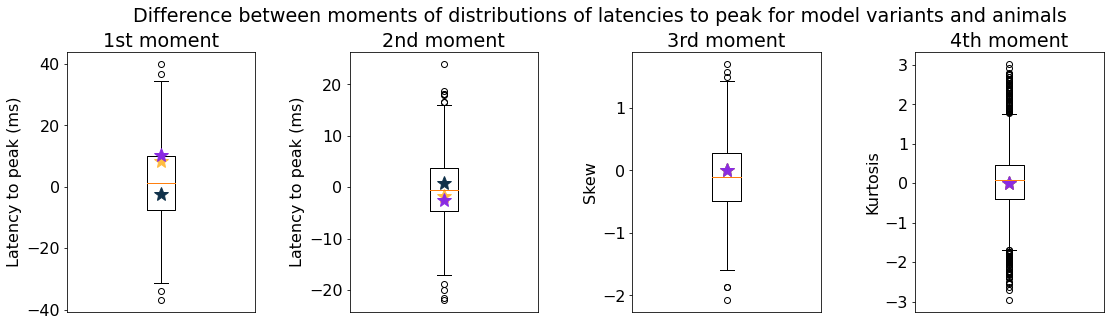

In [109]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4.5), sharex = True)

fig.subplots_adjust(wspace = 0.5, left = 0.05, right = 0.77, bottom = 0.05, top = 0.85)

ax = axes[0]
ax.boxplot(np.array(list(sessions_diff_peak_latencies.values())))

for sim_names in sims_diff_peak_latencies.keys():
    diff_peak_latency = sims_diff_peak_latencies[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_peak_latency, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_ylabel('Latency to peak (ms)')
ax.set_title('1st moment')
    
ax = axes[1]
ax.boxplot(np.array(list(sessions_diff_2nd_mom_lat.values())))
for sim_names in sims_diff_2nd_mom_lat.keys():
    diff_2nd_mom_peak_lat_sims = sims_diff_2nd_mom_lat[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_2nd_mom_peak_lat_sims, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_ylabel('Latency to peak (ms)')
ax.set_title('2nd moment')
    
ax = axes[2]
ax.boxplot(np.array(list(sessions_diff_3rd_mom_lat.values())))
for sim_names in sims_diff_3rd_mom_lat.keys():
    diff_3rd_mom_peak_lat_sims = sims_diff_3rd_mom_lat[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_3rd_mom_peak_lat_sims, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_title('3rd moment')
ax.set_ylabel('Skew')


ax = axes[3]
ax.boxplot(np.array(list(sessions_diff_4th_mom_lat.values())))
for sim_names in sims_diff_4th_mom_lat.keys():
    diff_4th_mom_peak_lat_sims = sims_diff_4th_mom_lat[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_4th_mom_peak_lat_sims, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)
    
ax.set_title('4th moment')
ax.set_ylabel('Kurtosis')


#ax.legend(bbox_to_anchor = (1,1))

ax.set_xticks([])

fig.suptitle('Difference between moments of distributions of latencies to peak for model variants and animals', y = 0.99, x = 0.42)

fig_name = 'moments_difference_peak_latencies_distributions_E'+sel_layer+'.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w', bbox_to_inches = 'tight')

In [110]:
fig_dir

'Figures/Supplementary_figures/quant_ver_fig5'

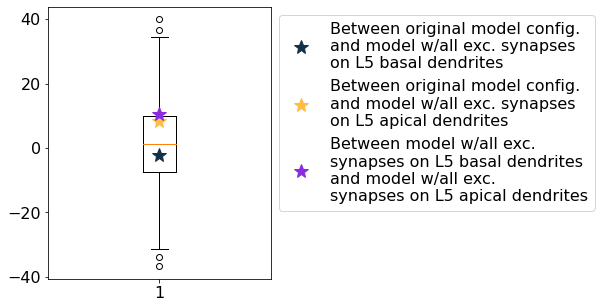

In [111]:
fig, ax = plt.subplots(figsize = (4,5))

ax.boxplot(np.array(list(sessions_diff_peak_latencies.values())))

for sim_names in sims_diff_peak_latencies.keys():
    diff_peak_latency = sims_diff_peak_latencies[sim_names]
    
    sims_label = sims_diff_manip_labels[sim_names]
    
    ax.plot(1, diff_peak_latency, '*', markersize = 15, color = sims_diff_manip_colors[sim_names], label = sims_label)

ax.legend(bbox_to_anchor = (1,1)) 

## CSD

In [147]:
csd_manip_sims = dict()

selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
csd_sims = find_files(selected_sims_data_dir, filename = 'csd_total.npy')
'''for sim_name in list(csd_sims.keys()):
    if 'old' in sim_name and '5' not in sel_layer:
        csd_manip_sims[sim_name] = csd_sims[sim_name]
    
selected_sims_data_dir = os.path.join(sim_data_dir, 'other_sims_fig5')
csd_sims = find_files(selected_sims_data_dir, filename = 'csd_total.npy')
for sim_name in list(csd_sims.keys()):
    if sel_layer not in sim_name:
        continue
    csd_manip_sims[sim_name] = csd_sims[sim_name]
    
csd_sims = csd_manip_sims'''
print('Total CSD from model versions: ', list(csd_sims.keys()))

old_model
intermediate_model
final_model
Total CSD from model versions:  ['old_model', 'intermediate_model', 'final_model']


In [148]:
csd_sims.keys()

dict_keys(['old_model', 'intermediate_model', 'final_model'])

In [149]:
sims_sinks = dict()
sims_sources = dict()

sims_csd_interp = dict()
sp_len = 30; t_len = 100
n_chans_in_cortex_sim = 21
for sim_name in csd_sims.keys():
    z = csd_sims[sim_name]['trial_avg'][:n_chans_in_cortex_sim,tstim_onset_sim:tstim_onset_sim+100]
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)

    sims_csd_interp[sim_name] = csd_interp

    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0

    sinks_interp = np.zeros_like(csd_interp)
    sources_interp = np.zeros_like(csd_interp)

    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])

    sims_sinks[sim_name] = sinks_interp / sinks_interp.sum()
    sims_sources[sim_name] = sources_interp / sources_interp.sum()


    sims_sinks_list = np.array(list(sims_sinks.values()))
    sims_sources_list = np.array(list(sims_sources.values()))

In [150]:
#sims_sinks[sim_name] = sinks_interp / sinks_interp.sum()
#sims_sources[sim_name] = sources_interp / sources_interp.sum()


sims_sinks_list = np.array(list(sims_sinks.values()))
sims_sources_list = np.array(list(sims_sources.values()))

In [151]:
#n_animals = len(sinks_mice)
# for sinks
compNr = 0 # selecting PC 1 component
sink_matrix_sims = compute_dist_matrix_exp(sims_sinks_list, sims_sinks_list, mode = 'pairwise_exp')

# for sources
source_matrix_sims = compute_dist_matrix_exp(sims_sources_list, sims_sources_list, mode = 'pairwise_exp')

# sum wasserstein distances calculated for sinks and sources into one matrix of Wasserstein distances from 
# individual animals to PC 1 CSD
dist_matrix_sims = sink_matrix_sims+source_matrix_sims

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


In [152]:
dist_matrix_sims

array([[0.        , 0.01324645, 0.08399145],
       [0.01324645, 0.        , 0.05413185],
       [0.08399145, 0.05413185, 0.        ]])

In [153]:
dist_matrix_sims

array([[0.        , 0.01324645, 0.08399145],
       [0.01324645, 0.        , 0.05413185],
       [0.08399145, 0.05413185, 0.        ]])

In [155]:
sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

sp_len = 30; t_len = 100
for i_sess, session_id in enumerate(sessions_csd_trial_avg_short.keys()):
    csd_trial_avg = sessions_csd_trial_avg_short[session_id]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()

In [156]:
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

In [157]:
n_animals = len(sinks_mice)
# for sinks
compNr = 0 # selecting PC 1 component
sink_matrix_exp_pairwise = compute_dist_matrix_exp(sinks_mice[:n_animals], sinks_mice[:n_animals], mode = 'pairwise_exp')

# for sources
source_matrix_exp_pairwise = compute_dist_matrix_exp(sources_mice[:n_animals], sources_mice[:n_animals], mode = 'pairwise_exp')

# sum wasserstein distances calculated for sinks and sources into one matrix of Wasserstein distances from 
# individual animals to PC 1 CSD
dist_matrix_exp_pairwise = sink_matrix_exp_pairwise+source_matrix_exp_pairwise

100%|██████████| 44/44 [10:29<00:00, 14.30s/it]


In [158]:
dist_matrix_exp_pairwise_orig = dist_matrix_exp_pairwise.copy()

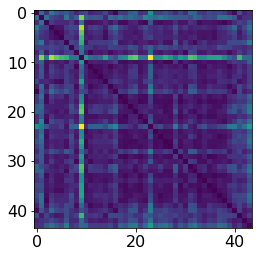

In [159]:
plt.imshow(dist_matrix_exp_pairwise)

In [160]:
dist_matrix_exp_pairwise_flat = []
for i in range(dist_matrix_exp_pairwise.shape[0]):
    for j in range(i+1, dist_matrix_exp_pairwise.shape[1]):
        dist_matrix_exp_pairwise_flat.append(dist_matrix_exp_pairwise[i,j])

In [161]:
dist_matrix_exp_pairwise_flat = np.array(dist_matrix_exp_pairwise_flat)

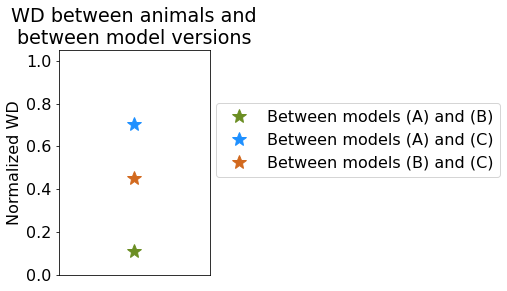

In [163]:
fig, axes = plt.subplots(figsize = (7.5,4))

fig.subplots_adjust(left = 0.12, right = 0.4, bottom = 0.05, top = 0.83)

ax = axes



#bp = ax.boxplot(dist_matrix_exp_pairwise_flat/dist_matrix_exp_pairwise_flat.max())#, patch_artist = True, \
                         #boxprops=dict(facecolor="white"), labels = ['Pairwise WD\n betweenanimals'])

#first_legend = plt.legend([bp["boxes"][0]], ['Pairwise WD\nbetween animals'], \
#                          frameon = False, columnspacing = 1, handletextpad = 0.88, ncol = 1, 
#                          loc = (1.05,0.52), fontsize = 15)
#plt.gca().add_artist(first_legend)

ax = axes
ax.plot(1,dist_matrix_sims[0,1]/dist_matrix_exp_pairwise_flat.max(), '*', markersize = 15, color = 'olivedrab', 
        label = 'Between models (A) and (B)')
ax.plot(1,dist_matrix_sims[0,2]/dist_matrix_exp_pairwise_flat.max(), '*', markersize = 15, color = 'dodgerblue',
        label = 'Between models (A) and (C)')
ax.plot(1,dist_matrix_sims[1,2]/dist_matrix_exp_pairwise_flat.max(), '*', markersize = 15, color = 'chocolate', 
        label = 'Between models (B) and (C)')

ax.legend(bbox_to_anchor = (0.99,0.8), frameon = True)

ax.set_ylabel('Normalized WD')
ax.set_title('WD between animals and\nbetween model versions')

ax.set_ylim([0, 1.05])

ax.set_xticks([])

fig_name = 'WD_between_model_versions_and_pairwise_WD_animals_wo_boxplot.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w', bbox_to_inches = 'tight')